# CNTK Reinforcement Learning Workshop
*Aayush Garg & Willi Richert (BLIS team) with great support from Lihong Li (MSR)*

In some ML/DL settings, we don't have immediate access to labels, so we cannot rely on supervised learning techniques. If, however, there is something we can interact with and thereby get some feedback that tells us occasionally, whether our previous behavior was good or not, we can use Reinforment Learning (RL) to learn how to improve our behavior. 

The goal of RL is to find _policies_, that maximize the _reward_ (feedback) through interaction with some environment. So given a series of experiences $$s \xrightarrow{a} r, s'$$ we then can learn how to chose action $a$ in a given state $s$ to maximize the accumulated reward $r$ over time: 
\begin{align}
Q(s,a) &= r_0 + \gamma r_1 + \gamma^2 r_2 + \ldots \newline
&= r_0 + \gamma \max_a Q^*(s',a)
\end{align}
where $\gamma \in [0,1)$ is the discount factor that controls how much we should value reward that is further away. This is called the $Bellmann$-equation. 

The question is now how to model the state space and then how to use the received reward to figure out, which action yields the highest future reward. If we just knew the optimal function $Q^*(s,a)$ ...

In this workshop we will encounter two different ways how to approach this:

**Deep Q-Networks** - DQNs have become famous in 2015 when they were successfully used to train how to play Atari just form raw pixels. We train a NN to learn the the $Q(s,a)$ values (thus _Q-Network _), which we then can use to choose the best action.

**Policy gradient** methods directly estimate the policy in the network. The outcome is a probability of which action to choose in order to maximize the reward.

However, we will have a very shallow interpretation of "deep", since we are more concerned with how to implement RL in CNTK. Going deep is then just a matter of using yesterday learned techniques and replace our simple input space with those deep layers.

## Before we start...
verify that the following imports work in your notebook.

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import seaborn
import gym

In [7]:
import cntk as C

# CartPole

We will use the [CartPole](https://gym.openai.com/envs/CartPole-v0) environment from OpenAI's [gym](https://github.com/openai/gym) simulator to teach a cart to balance a pole. 

In every time step, the agent
 * gets an observation $(x, \dot{x}, \theta, \dot{\theta})$
 * performs an action `LEFT` or `RIGHT`.
 * receives 
  * a reward of +1 for having survived another time step
  * a new state $(x', \dot{x}', \theta', \dot{\theta}')$
 
The episode ends, if 
 * the pole is more than 15 degrees from vertical
 * the cart is moving more than 2.4 units from center
 
The task is considered done, if
 * the agent achieved and averaged reward of 200 over the last 50 episodes (if you manage to get a reward of 200 averaged over the last 100 episode you can consider submitting it to OpenAI :-)) 

Let's play it!

In [8]:
def play():
    env = gym.make('CartPole-v0')
    env.reset()
    env.render()
    
    while True:        
        key = input()
        if key=='a':
            env.step(0)
        elif key=='s':
            env.step(1)
        else:
            break
        env.render()
# play() # <- uncomment this line and hit Ctrl-Enter

# Part 1: DQN

After a transition $(s,a,r,s′)$, we are trying to move our value function $Q(s,a)$ closer to our target $r+\gamma \max_{a′}Q(s′,a′)$.

DQNs
 * learn the _Q-function_ that maps observation -> score
 * use memory replay to decorrelate experiences (sequence state transitions)
 * use a second network to stabilize learning (in this workshop we skip this)

### Setting up the graph
\begin{equation}
l_1 = relu( x W_1 + b_1) \\
Q(s,a) = l_1 W_2 + b_2 \\
\end{equation}

We will start with a slightly modified version for Keras, https://github.com/jaara/AI-blog/blob/master/CartPole-basic.py, published by Jaromír Janisch in his [AI blog](https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/), and will then gradually convert it to use CNTK.

In [9]:
import random, numpy, math, gym

#from keras.models import Sequential
#from keras.layers import *
#from keras.optimizers import *
from cntk import *
from cntk.models import Sequential
from cntk.layers import *

In [10]:
env = gym.make('CartPole-v0')

STATE_COUNT  = env.observation_space.shape[0]
ACTION_COUNT = env.action_space.n

STATE_COUNT, ACTION_COUNT

[2016-10-27 07:06:36,978] Making new env: CartPole-v0


(4, 2)

In [11]:
BATCH_SIZE_BASELINE = 50  # calculate average reward over these many episodes
H = 64 # hidden layer size

class Brain:
    def __init__(self):
        self.params = {}
        self.model, self.trainer, self.loss = self._create()
        # self.model.load_weights("cartpole-basic.h5")
        
    def _create(self):
        observation = input_variable(STATE_COUNT, np.float32, name="s")
        q_target = input_variable(ACTION_COUNT, np.float32, name="q")

        # model = Sequential()
        # model.add(Dense(output_dim=64, activation='relu', input_dim=STATE_COUNT))
        # model.add(Dense(output_dim=ACTION_COUNT, activation='linear'))

        l1 = Dense(H, activation=relu)
        l2 = Dense(ACTION_COUNT)
        unbound_model = Sequential([l1, l2])
        model = unbound_model(observation)

        self.params = dict(W1=l1.W, b1=l1.b, W2=l2.W, b2=l2.b)            
        
        lr = 0.00025
        # opt = RMSprop(lr=0.00025)
        # model.compile(loss='mse', optimizer=opt)

        # loss='mse'
        loss = reduce_mean(square(model - q_target), axis=0)
        meas = reduce_mean(square(model - q_target), axis=0)

        # optimizer=opt
        lr /= BATCH_SIZE
        learner = sgd(model.parameters, lr, gradient_clipping_threshold_per_sample=10)
        trainer = Trainer(model, loss, meas, learner)

        # CNTK: return trainer and loss as well
        return model, trainer, loss

    def train(self, x, y, epoch=1, verbose=0):
        #self.model.fit(x, y, batch_size=64, nb_epoch=epoch, verbose=verbose)
        arguments = dict(zip(self.loss.arguments, [y,x]))
        updated, results =self.trainer.train_minibatch(arguments, outputs=[self.loss.output])

    def predict(self, s):
        return self.model.eval(s)

In [12]:
class Memory:   # stored as ( s, a, r, s_ )
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

In [13]:
MEMORY_CAPACITY = 100000
BATCH_SIZE = 64

GAMMA = 0.99 # discount factor

MAX_EPSILON = 1
MIN_EPSILON = 0.01 # stay a bit curious even when getting old
LAMBDA = 0.0001    # speed of decay

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self):
        self.brain = Brain()
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, ACTION_COUNT-1)
        else:
            return numpy.argmax(self.brain.predict(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = numpy.zeros(STATE_COUNT)

        
        # CNTK: explicitly setting to float32
        states = numpy.array([ o[0] for o in batch ], dtype=np.float32)
        states_ = numpy.array([(no_state if o[3] is None else o[3]) for o in batch ], dtype=np.float32)

        p = agent.brain.predict(states)
        p_ = agent.brain.predict(states_)

        # CNTK: explicitly setting to float32
        x = numpy.zeros((batchLen, STATE_COUNT)).astype(np.float32)
        y = numpy.zeros((batchLen, ACTION_COUNT)).astype(np.float32)
        
        for i in range(batchLen):
            s, a, r, s_ = batch[i]
            
            # CNTK: [0] because of sequence dimension
            t = p[0][i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * numpy.amax(p_[0][i])

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

### Brain surgery

In [14]:
def plot_weights(weights, figsize=(7,5)):
    '''Heat map of weights to see which neurons play which role'''
    sns.set(style="white")
    f, ax = plt.subplots(len(weights), figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    for i, data in enumerate(weights):
        axi = ax if len(weights)==1 else ax[i]
        if isinstance(data, tuple): 
            w, title = data
            axi.set_title(title)
        else:
            w = np.asarray(data)
        sns.heatmap(w, cmap=cmap, square=True, center=True, #annot=True,
                    linewidths=.5, cbar_kws={"shrink": .25}, ax=axi)

### Exploration - exploitation trade-off

In [15]:
def epsilon(steps):
    return MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-LAMBDA * steps)
plt.plot(range(10000), [epsilon(x) for x in range(10000)], 'r')
plt.xlabel('step');plt.ylabel('$\epsilon$')

In [35]:
def run(agent):
    s = env.reset()
    R = 0 

    while True:            
        #env.render()

        # CNTK: explicitly setting to float32
        a = agent.act(s.astype(np.float32))

        s_, r, done, info = env.step(a)

        if done: # terminal state
            s_ = None

        agent.observe((s, a, r, s_))
        agent.replay()            

        s = s_
        R += r

        if done:
            return R

agent = Agent()

episode_number = 0
reward_sum = 0
while episode_number<200:
    reward_sum += run(agent)
    episode_number += 1
    if episode_number % BATCH_SIZE_BASELINE == 0:
        print('Episode: %d, Average reward for episode %f.' % (episode_number, reward_sum / BATCH_SIZE_BASELINE))
        if episode_number%3000==0:
            plot_weights([(agent.brain.params['W1'], 'Episode %i $W_1$'%episode_number)], figsize=(14,5))
        if reward_sum / BATCH_SIZE_BASELINE > 200:
            print('Task solved in %d episodes' % episode_number)
            plot_weights([(agent.brain.params['W1'], 'Episode %i $W_1$'%episode_number)], figsize=(14,5))            
            break
        reward_sum = 0
agent.brain.model.save_model('dqn.mod', False)

Episode: 50, Average reward for episode 24.120000.
Episode: 100, Average reward for episode 18.240000.
Episode: 150, Average reward for episode 18.860000.
Episode: 200, Average reward for episode 19.220000.


If you run it, you should see something like

```[2016-10-26 22:06:25,436] Making new env: CartPole-v0
Episode: 50, Average reward for episode 23.700000.
Episode: 100, Average reward for episode 18.720000.
Episode: 150, Average reward for episode 17.960000.
...
Episode: 1750, Average reward for episode 100.180000.
Episode: 1800, Average reward for episode 111.380000.
Episode: 1850, Average reward for episode 207.240000.
Task solved in 1850 episodes```

#### Task 1.1
Rewrite the model without using the layer lib.
#### Task 1.2
Play with different [learners](https://cntk.ai/pythondocs/cntk.learner.html?highlight=learner#module-cntk.learner). Which one works better? Worse? Think about which parameters you would need to adapt when switching from one learner to the other.

### Running the DQN model

In [22]:
env = gym.make('CartPole-v0')

upper_bound_reward = 1000  # set max rewards possible in one episode
num_episodes = 1  # number of episodes to run

modelPath = 'dqn.mod'
root = C.load_model(modelPath)

agent = Agent()

for i_episode in range(num_episodes):
    observation = env.reset()  # reset environment for new episode
    for t in range(upper_bound_reward):
        env.render()
        action = np.argmax(agent.brain.predict(observation.astype(np.float32)))
        observation, reward, done, info = env.step(action)
        

[2016-10-27 07:11:06,257] Making new env: CartPole-v0
[2016-10-27 07:11:06,501] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


AttributeError: 'NoneType' object has no attribute 'flip'

# Part 2: Policy gradient
**Goal:** 
\begin{equation}\text{maximize } E [R | \pi_\theta]
\end{equation}

**Approach:**
1. Collect experience (sample a bunch of trajectories through $(s,a)$ space)
2. Update the policy so that _good_ experiences become more probable

**Difference to DQN: **
 * we don't consider single $(s,a,r,s')$ transitions, but rather use whole episodes for the gradient updates
 * our parameters directly model the policy (output is an action probability), whereas in DQN they model the value function (output is raw score)

### Rewards
Remember, we get +1 reward for every time step, in which we still were in the game. 

The problem: we normally do not know, which action led to a continuation of the game, and which was actually a bad one. Our simple heuristic: actions in the beginning of the episode are good, and those towards the end are likely bad (they led to losing the game after all).

In [12]:
def discount_rewards(r, gamma=0.999):
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [13]:
discounted_epr = discount_rewards(np.ones(10))
f, ax = plt.subplots(1, figsize=(5,2))
sns.barplot(list(range(10)), discounted_epr, color="steelblue")

We normalize the rewards so that they tank below zero towards the end. gamma controls how late the rewards tank.

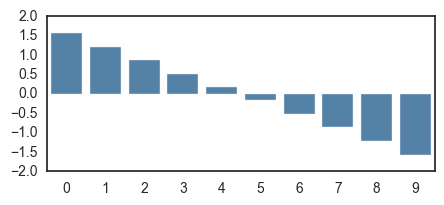

In [14]:
discounted_epr_cent = discounted_epr - np.mean(discounted_epr)
discounted_epr_norm = discounted_epr_cent/np.std(discounted_epr_cent)
f, ax = plt.subplots(1, figsize=(5,2))
sns.barplot(list(range(10)), discounted_epr_norm, color="steelblue")

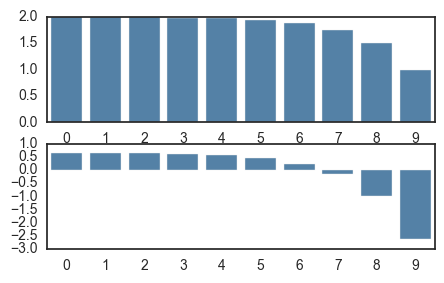

In [15]:
discounted_epr = discount_rewards(np.ones(10), gamma=0.5)
discounted_epr_cent = discounted_epr - np.mean(discounted_epr)
discounted_epr_norm = discounted_epr_cent/np.std(discounted_epr_cent)
f, ax = plt.subplots(2, figsize=(5,3))
sns.barplot(list(range(10)), discounted_epr, color="steelblue", ax=ax[0])
sns.barplot(list(range(10)), discounted_epr_norm, color="steelblue", ax=ax[1])

### Setting up the graph
\begin{equation}
l_1 = relu( x W_1 + b_1) \\
l_2 = l_1 W_2 + b_2 \\
\pi(a|s) = sigmoid(l2)
\end{equation}

In [16]:
import cntk as C # DTRT (TM)

TOTAL_EPISODES = 10000
D = 4  # input dimensionality
H = 10 # number of hidden layer neurons

observations = C.input_variable(shape=STATE_COUNT, data_type=np.float32, name="obs")

W1 = C.parameter(shape=(STATE_COUNT, H), init=C.glorot_uniform(), name="W1")
b1 = C.parameter(shape=H, name="b1")
layer1 = C.relu(C.times(observations, W1) + b1)

W2 = C.parameter(shape=(H, ACTION_COUNT), init=C.glorot_uniform(), name="W2")
b2 = C.parameter(shape=ACTION_COUNT, name="b2")
score = C.times(layer1, W2) + b2
# Until here it was similar to DQN

probability = C.sigmoid(score, name="prob")

In [17]:
input_y = C.input_variable(shape=1, data_type=np.float32, name="input_y")
advantages = C.input_variable(shape=1, data_type=np.float32, name="advt")

loss = -C.reduce_mean(C.log(C.square(input_y - probability) + 1e-4) * advantages, axis=0, name='loss')

lr = 0.001 
sgd = C.sgd([W1, W2], lr)

gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

xs, hs, label, drs = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 1

observation = env.reset()

while episode_number <= TOTAL_EPISODES:
    x = np.reshape(observation, [1, STATE_COUNT]).astype(np.float32)

    # Run the policy network and get an action to take.
    prob = probability.eval(arguments={observations: x})[0][0][0]
    action = 1 if np.random.uniform() < prob else 0

    xs.append(x)  # observation
    # grad that encourages the action that was taken to be taken

    y = 1 if action == 0 else 0  # a "fake label"
    label.append(y)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += float(reward)

    # Record reward (has to be done after we call step() to get reward for previous action)
    drs.append(float(reward))

    if done:
        # Stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        epl = np.vstack(label).astype(np.float32)
        epr = np.vstack(drs).astype(np.float32)
        xs, label, drs = [], [], []  # reset array memory

        # Compute the discounted reward backwards through time.
        discounted_epr = discount_rewards(epr)
        # Size the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        # Forward pass
        arguments = {observations: epx, input_y: epl, advantages: discounted_epr}
        state, outputs_map = loss.forward(arguments, outputs=loss.outputs, keep_for_backward=loss.outputs)
        
        # Backward psas
        root_gradients = {v: np.ones_like(o) for v, o in outputs_map.items()}
        vargrads_map = loss.backward(state, root_gradients, variables=set([W1, W2]))

        for var, grad in vargrads_map.items():
            gradBuffer[var.name] += grad

        # Wait for some batches to finish to reduce noise
        if episode_number % BATCH_SIZE == 0:
            grads = {W1: gradBuffer['W1'].astype(np.float32), W2: gradBuffer['W2'].astype(np.float32)}
            updated = sgd.update(grads, BATCH_SIZE)

            # reset the gradBuffer
            gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

            print('Episode: %d. Average reward for episode %f.' % (episode_number, reward_sum / BATCH_SIZE))

            if reward_sum / BATCH_SIZE > 200:
                print('Task solved in: %d ' % episode_number)
                break

            reward_sum = 0

        observation = env.reset()  # reset env
        episode_number += 1
agent.brain.model.save_model('pg.mod', False)

Episode: 64. Average reward for episode 17.968750.
Episode: 128. Average reward for episode 18.140625.
Episode: 192. Average reward for episode 17.343750.
Episode: 256. Average reward for episode 22.046875.
Episode: 320. Average reward for episode 18.703125.
Episode: 384. Average reward for episode 16.859375.
Episode: 448. Average reward for episode 17.328125.
Episode: 512. Average reward for episode 18.046875.
Episode: 576. Average reward for episode 19.343750.
Episode: 640. Average reward for episode 20.140625.
Episode: 704. Average reward for episode 22.109375.
Episode: 768. Average reward for episode 21.656250.
Episode: 832. Average reward for episode 23.562500.
Episode: 896. Average reward for episode 28.687500.
Episode: 960. Average reward for episode 31.578125.
Episode: 1024. Average reward for episode 34.187500.
Episode: 1088. Average reward for episode 40.593750.
Episode: 1152. Average reward for episode 49.781250.
Episode: 1216. Average reward for episode 43.343750.
Episode: 

### Running a saved policy gradient model

In [34]:
env = gym.make('CartPole-v0')

upper_bound_reward = 1000  # set max rewards possible in one episode
num_episodes = 1  # number of episodes to run

modelPath = 'pg.mod'
root = C.load_model(modelPath)

for i_episode in range(num_episodes):
    observation = env.reset()  # reset environment for new episode
    for t in range(upper_bound_reward):
        env.render()
        x = np.reshape(observation, [1, STATE_COUNT]).astype(np.float32)
        tfprob = root.eval(arguments={"obs": x})
        tfprob = tfprob[0][0][0]

        action = 1 if tfprob >= 0.5 else 0
        observation, reward, done, info = env.step(action)

[2016-10-27 06:38:53,554] Making new env: CartPole-v0


observation: [-0.00537287  0.02553991  0.03486672  0.02295289]


ValueError: variable with name "obs" does not exist in the network. Available variable names: s

# Solutions
#### Solution 1.1

In [18]:
observation = input_variable(STATE_COUNT, np.float32, name="s")

W1 = parameter(shape=(STATE_COUNT, H), init=glorot_uniform(), name="W1")
b1 = parameter(shape=H, name="b1")
layer1 = relu(times(observation, W1) + b1)
W2 = parameter(shape=(H, ACTION_COUNT), init=glorot_uniform(), name="W2")
b2 = parameter(shape=ACTION_COUNT, name="b2")
model = times(layer1, W2) + b2
W1.shape, b1.shape, W2.shape, b2.shape, model.shape

((4, 10), (10,), (10, 2), (2,), (2,))